# Práctica: Detección de Anomalías con Machine Learning
## Análisis de Temperaturas en Dispositivo Industrial

**Estudiante:** [Tu nombre]

**Fecha:** Octubre 2025

---

Esta práctica implementa tres técnicas diferentes de Machine Learning para detectar anomalías en un dataset de temperaturas:

1. **LSTM (Long Short-Term Memory)** - 5 puntos
2. **Autoencoder** - 2.5 puntos
3. **Isolation Forest** - 2.5 puntos

## 📦 Instalación de Dependencias

Primero instalamos todas las librerías necesarias:

In [1]:
# Instalar dependencias (descomentar si es necesario)
# !pip install numpy pandas matplotlib seaborn scikit-learn tensorflow pyod

## 📚 Importación de Librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

2025-10-30 18:34:12.972588: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 18:34:12.993961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-30 18:34:12.993973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-30 18:34:12.993989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-30 18:34:12.998114: I tensorflow/core/platform/cpu_feature_g

✅ Librerías importadas correctamente
TensorFlow version: 2.14.0
NumPy version: 1.26.0
Pandas version: 2.3.3


## 📊 Carga y Exploración de Datos

In [3]:
# Cargar los datos
df = pd.read_csv('datos.csv', parse_dates=['timestamp'])

print("📋 Información del Dataset:")
print(f"Forma del dataset: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head(10))
print(f"\nEstadísticas descriptivas:")
print(df.describe())
print(f"\nValores nulos: {df.isnull().sum().sum()}")
print(f"\nRango de fechas: {df['timestamp'].min()} a {df['timestamp'].max()}")

📋 Información del Dataset:
Forma del dataset: (7267, 2)

Primeras filas:
            timestamp      value
0 2013-07-04 00:00:00  69.880835
1 2013-07-04 01:00:00  71.220227
2 2013-07-04 02:00:00  70.877805
3 2013-07-04 03:00:00  68.959400
4 2013-07-04 04:00:00  69.283551
5 2013-07-04 05:00:00  70.060966
6 2013-07-04 06:00:00  69.279765
7 2013-07-04 07:00:00  69.369608
8 2013-07-04 08:00:00  69.166714
9 2013-07-04 09:00:00  68.986083

Estadísticas descriptivas:
                           timestamp        value
count                           7267  7267.000000
mean   2013-12-17 01:43:01.477914112    71.242433
min              2013-07-04 00:00:00    57.458406
25%              2013-10-01 13:30:00    68.369411
50%              2013-12-19 04:00:00    71.858493
75%              2014-03-06 01:30:00    74.430958
max              2014-05-28 15:00:00    86.223213
std                              NaN     4.247509

Valores nulos: 0

Rango de fechas: 2013-07-04 00:00:00 a 2014-05-28 15:00:00


### Visualización Inicial de los Datos

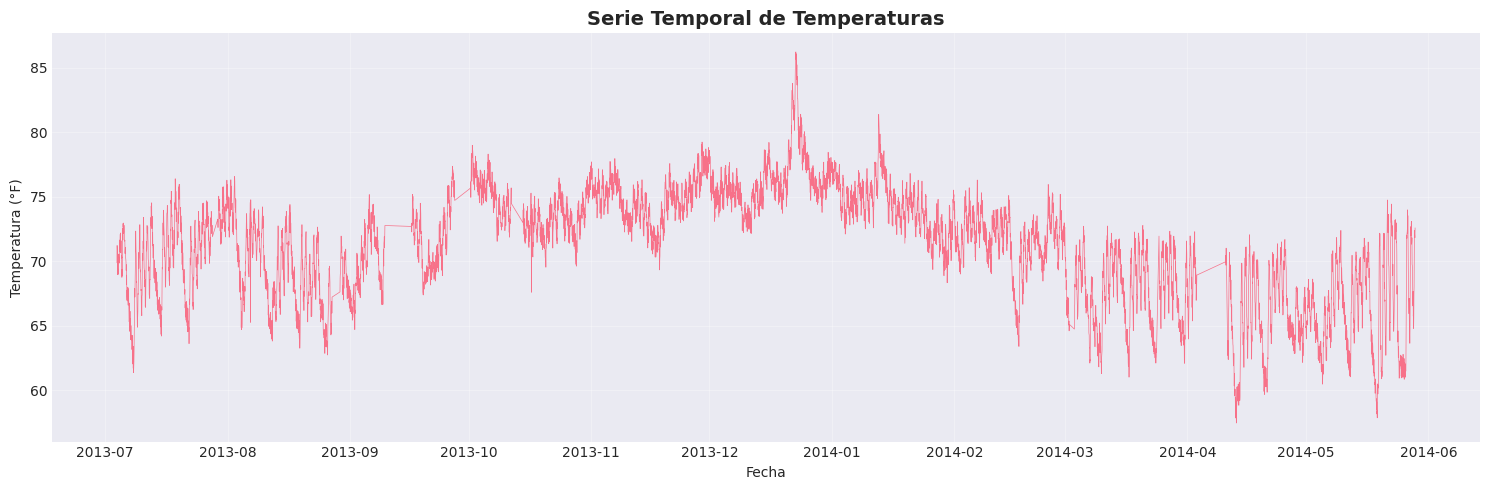

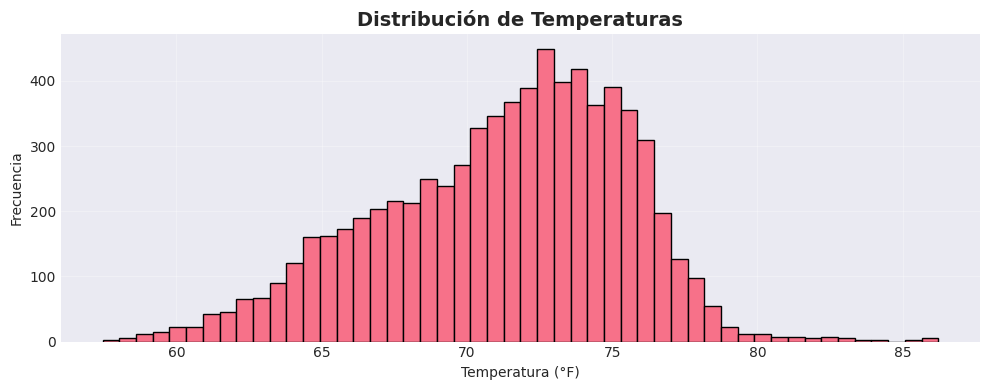

In [4]:
# Gráfica de la serie temporal completa
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], linewidth=0.5)
plt.title('Serie Temporal de Temperaturas', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°F)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histograma de valores
plt.figure(figsize=(10, 4))
plt.hist(df['value'], bins=50, edgecolor='black')
plt.title('Distribución de Temperaturas', fontsize=14, fontweight='bold')
plt.xlabel('Temperatura (°F)')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

# 1️⃣ LSTM para Detección de Anomalías (5 puntos)

## 1.a) Construcción del Modelo Básico LSTM (2 puntos)

### Preparación de los Datos para LSTM

In [5]:
def create_sequences(data, window_size):
    """
    Crea secuencias (ventanas) de datos para entrenar el modelo LSTM.
    
    Args:
        data: Array de valores de temperatura
        window_size: Tamaño de la ventana de entrada
    
    Returns:
        X: Secuencias de entrada (ventanas)
        y: Valores objetivo (siguiente valor después de cada ventana)
    """
    X, y = [], []
    
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    
    return np.array(X), np.array(y)

# Parámetros
WINDOW_SIZE = 24  # Ventana de 24 horas
TRAIN_SPLIT = 0.8  # 80% para entrenamiento, 20% para validación

# Preparar los datos
values = df['value'].values

# Crear secuencias
X, y = create_sequences(values, WINDOW_SIZE)

# Dividir en entrenamiento y validación
split_idx = int(len(X) * TRAIN_SPLIT)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Reshape para LSTM: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

print(f"✅ Datos preparados:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

✅ Datos preparados:
X_train shape: (5794, 24, 1)
y_train shape: (5794,)
X_val shape: (1449, 24, 1)
y_val shape: (1449,)


### Construcción del Modelo LSTM Básico

In [6]:
def build_basic_lstm_model(window_size, lstm_units=50):
    """
    Construye un modelo LSTM básico para predicción de series temporales.
    
    Args:
        window_size: Tamaño de la ventana de entrada
        lstm_units: Número de unidades en la capa LSTM
    
    Returns:
        model: Modelo LSTM compilado
    """
    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Crear el modelo
model_basic = build_basic_lstm_model(WINDOW_SIZE)

# Mostrar arquitectura
print("🏗️ Arquitectura del Modelo LSTM Básico:")
model_basic.summary()

🏗️ Arquitectura del Modelo LSTM Básico:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-10-30 18:34:13.960269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


### Entrenamiento del Modelo LSTM Básico

In [7]:
# Callback para early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
print("🏋️ Entrenando modelo LSTM básico...")
history_basic = model_basic.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Entrenamiento completado")

🏋️ Entrenando modelo LSTM básico...
Epoch 1/50
182/182 [==============================] - 1s 4ms/step - loss: 41.2234 - mae: 2.7800 - val_loss: 7.6402 - val_mae: 2.1161
Epoch 2/50
182/182 [==============================] - 1s 3ms/step - loss: 2.8733 - mae: 1.3001 - val_loss: 7.1828 - val_mae: 2.0707
Epoch 3/50
182/182 [==============================] - 1s 3ms/step - loss: 2.6436 - mae: 1.2615 - val_loss: 6.1371 - val_mae: 2.0024
Epoch 4/50
182/182 [==============================] - 1s 3ms/step - loss: 2.0342 - mae: 1.0992 - val_loss: 3.0375 - val_mae: 1.2871
Epoch 5/50
182/182 [==============================] - 1s 3ms/step - loss: 1.2526 - mae: 0.8801 - val_loss: 2.2221 - val_mae: 1.1548
Epoch 6/50
182/182 [==============================] - 1s 3ms/step - loss: 1.0466 - mae: 0.8117 - val_loss: 2.0549 - val_mae: 1.1693
Epoch 7/50
182/182 [==============================] - 1s 3ms/step - loss: 2935.3467 - mae: 7.6417 - val_loss: 8.3340 - val_mae: 2.2205
Epoch 8/50
182/182 [================

### Visualización del Entrenamiento

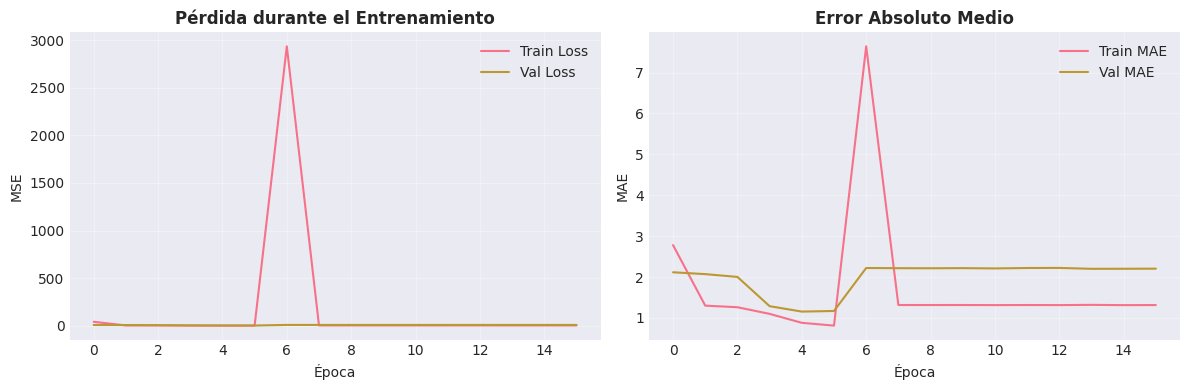

In [8]:
# Gráfica de pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_basic.history['loss'], label='Train Loss')
plt.plot(history_basic.history['val_loss'], label='Val Loss')
plt.title('Pérdida durante el Entrenamiento', fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_basic.history['mae'], label='Train MAE')
plt.plot(history_basic.history['val_mae'], label='Val MAE')
plt.title('Error Absoluto Medio', fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.b) Detección de Anomalías con LSTM (2 puntos)

In [9]:
def detect_anomalies_lstm(model, X, y, threshold_percentile=95):
    """
    Detecta anomalías usando el modelo LSTM entrenado.
    Una anomalía se detecta cuando el error de predicción supera un umbral.
    
    Args:
        model: Modelo LSTM entrenado
        X: Secuencias de entrada
        y: Valores reales
        threshold_percentile: Percentil para determinar el umbral de anomalía
    
    Returns:
        predictions: Predicciones del modelo
        errors: Errores absolutos
        anomalies: Índices de las anomalías detectadas
        threshold: Umbral usado para detectar anomalías
    """
    # Hacer predicciones
    predictions = model.predict(X, verbose=0).flatten()
    
    # Calcular errores absolutos
    errors = np.abs(predictions - y)
    
    # Definir umbral basado en percentil
    threshold = np.percentile(errors, threshold_percentile)
    
    # Detectar anomalías
    anomalies = np.where(errors > threshold)[0]
    
    return predictions, errors, anomalies, threshold

# Preparar todos los datos para detección
X_all, y_all = create_sequences(values, WINDOW_SIZE)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

# Detectar anomalías
predictions_basic, errors_basic, anomalies_basic, threshold_basic = detect_anomalies_lstm(
    model_basic, X_all, y_all, threshold_percentile=95
)

print(f"🔍 Detección de Anomalías - Modelo LSTM Básico")
print(f"El número de anomalías es {len(anomalies_basic)} sobre {len(y_all)}")
print(f"Umbral de error: {threshold_basic:.4f}")
print(f"\nFechas de las anomalías detectadas:")
print(anomalies_basic)
# Obtener las fechas de las anomalías (tomamos la primera fecha de la ventana)
for idx in anomalies_basic[:20]:  # Mostramos las primeras 20
    anomaly_timestamp = df['timestamp'].iloc[idx]
    print(anomaly_timestamp)

if len(anomalies_basic) > 20:
    print(f"... y {len(anomalies_basic) - 20} más")

🔍 Detección de Anomalías - Modelo LSTM Básico
El número de anomalías es 363 sobre 7243
Umbral de error: 2.0917

Fechas de las anomalías detectadas:
[  34   36   37   53   58   73   84   88   89   90  100  125  138  148
  172  173  200  213  221  253  256  258  270  291  304  330  370  372
  375  378  379  390  421  424  425  437  647  672  673  677  681  689
  690  691  694  699  701  730  732  756  757  816  863  865  879  921
  923  933  959  984 1008 1011 1015 1033 1037 1055 1066 1068 1098 1103
 1124 1169 1174 1177 1181 1198 1207 1314 1342 1463 1489 1505 1533 1534
 1566 1592 1596 1597 1695 1930 1949 2040 2091 2092 2099 2221 2289 2626
 2770 2798 2820 3180 3184 3204 3372 3673 3674 3678 3712 3716 3720 3736
 3788 3969 3992 4201 4259 4360 4422 4494 4554 4571 4617 4787 4980 5004
 5011 5012 5058 5059 5062 5063 5064 5231 5285 5290 5317 5334 5338 5340
 5342 5344 5356 5380 5426 5430 5432 5449 5452 5459 5475 5500 5503 5522
 5531 5534 5537 5550 5556 5568 5573 5598 5616 5620 5662 5668 5683 5688


### Visualización de Anomalías Detectadas

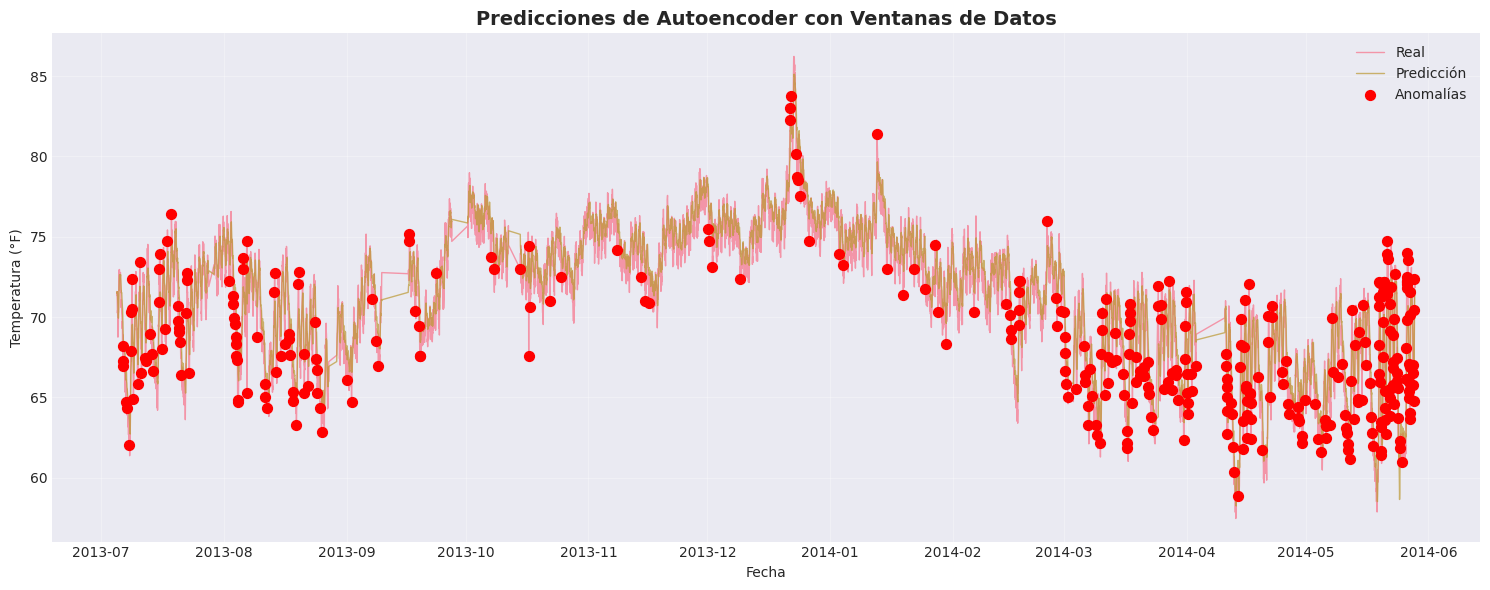

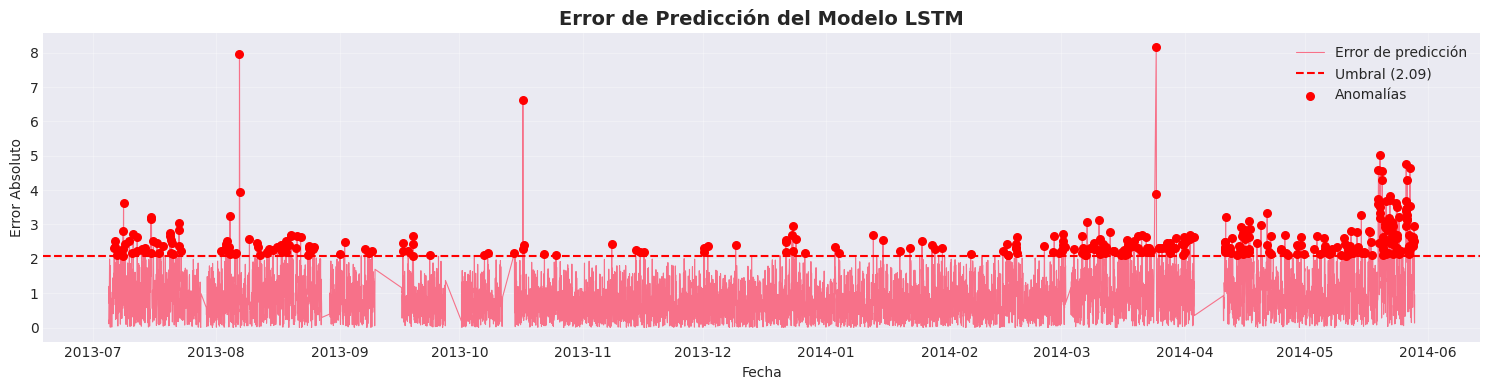

In [10]:
# Gráfica de predicciones vs valores reales con anomalías
plt.figure(figsize=(15, 6))

# Datos para visualización
timestamps = df['timestamp'].iloc[WINDOW_SIZE:].values

plt.plot(timestamps, y_all, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps, predictions_basic, label='Predicción', linewidth=1, alpha=0.7)
plt.scatter(timestamps[anomalies_basic], y_all[anomalies_basic], 
           color='red', label='Anomalías', s=50, zorder=5)

plt.title('Predicciones de Autoencoder con Ventanas de Datos', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°F)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica de errores
plt.figure(figsize=(15, 4))
plt.plot(timestamps, errors_basic, label='Error de predicción', linewidth=0.8)
plt.axhline(y=threshold_basic, color='r', linestyle='--', label=f'Umbral ({threshold_basic:.2f})')
plt.scatter(timestamps[anomalies_basic], errors_basic[anomalies_basic], 
           color='red', label='Anomalías', s=30, zorder=5)
plt.title('Error de Predicción del Modelo LSTM', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Error Absoluto')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.c) Mejora del Modelo LSTM (1 punto)

Vamos a aplicar **2 mejoras** al modelo básico:

1. **Normalización con MinMaxScaler**: Escalar los datos al rango [0, 1]
2. **Arquitectura más compleja**: Añadir más capas LSTM y Dropout para evitar overfitting

### Mejora 1: Normalización de Datos

In [11]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Crear secuencias con datos normalizados
X_scaled, y_scaled = create_sequences(values_scaled, WINDOW_SIZE)

# Dividir en entrenamiento y validación
X_train_scaled = X_scaled[:split_idx].reshape((X_scaled[:split_idx].shape[0], WINDOW_SIZE, 1))
X_val_scaled = X_scaled[split_idx:].reshape((X_scaled[split_idx:].shape[0], WINDOW_SIZE, 1))
y_train_scaled = y_scaled[:split_idx]
y_val_scaled = y_scaled[split_idx:]

print("✅ Datos normalizados con MinMaxScaler")
print(f"Rango original: [{values.min():.2f}, {values.max():.2f}]")
print(f"Rango escalado: [{values_scaled.min():.2f}, {values_scaled.max():.2f}]")

✅ Datos normalizados con MinMaxScaler
Rango original: [57.46, 86.22]
Rango escalado: [0.00, 1.00]


### Mejora 2: Arquitectura Mejorada del Modelo

In [12]:
def build_improved_lstm_model(window_size):
    """
    Construye un modelo LSTM mejorado con:
    - Múltiples capas LSTM
    - Dropout para regularización
    - Más unidades por capa
    """
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Crear el modelo mejorado
model_improved = build_improved_lstm_model(WINDOW_SIZE)

print("🏗️ Arquitectura del Modelo LSTM Mejorado:")
model_improved.summary()

🏗️ Arquitectura del Modelo LSTM Mejorado:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 24, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params

### Entrenamiento del Modelo Mejorado

In [13]:
# Entrenar el modelo mejorado
print("🏋️ Entrenando modelo LSTM mejorado...")
history_improved = model_improved.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Entrenamiento completado")

🏋️ Entrenando modelo LSTM mejorado...
Epoch 1/50
182/182 [==============================] - 3s 9ms/step - loss: 0.0192 - mae: 0.0931 - val_loss: 0.0089 - val_mae: 0.0815
Epoch 2/50
182/182 [==============================] - 1s 8ms/step - loss: 0.0052 - mae: 0.0583 - val_loss: 0.0078 - val_mae: 0.0755
Epoch 3/50
182/182 [==============================] - 1s 8ms/step - loss: 0.0044 - mae: 0.0538 - val_loss: 0.0071 - val_mae: 0.0713
Epoch 4/50
182/182 [==============================] - 1s 7ms/step - loss: 0.0035 - mae: 0.0478 - val_loss: 0.0070 - val_mae: 0.0708
Epoch 5/50
182/182 [==============================] - 1s 7ms/step - loss: 0.0031 - mae: 0.0444 - val_loss: 0.0068 - val_mae: 0.0688
Epoch 6/50
182/182 [==============================] - 1s 7ms/step - loss: 0.0025 - mae: 0.0396 - val_loss: 0.0067 - val_mae: 0.0663
Epoch 7/50
182/182 [==============================] - 1s 7ms/step - loss: 0.0022 - mae: 0.0369 - val_loss: 0.0051 - val_mae: 0.0552
Epoch 8/50
182/182 [==================

### Comparación de Resultados: Modelo Básico vs Mejorado

In [14]:
# Preparar datos escalados completos
X_all_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Detectar anomalías con modelo mejorado
predictions_improved, errors_improved, anomalies_improved, threshold_improved = detect_anomalies_lstm(
    model_improved, X_all_scaled, y_scaled, threshold_percentile=95
)

# Desnormalizar predicciones para visualización
predictions_improved_denorm = scaler.inverse_transform(predictions_improved.reshape(-1, 1)).flatten()

print("\n" + "="*60)
print("📊 COMPARACIÓN DE RESULTADOS")
print("="*60)

print("\n🔵 Modelo Básico:")
print(f"   - Anomalías detectadas: {len(anomalies_basic)}")
print(f"   - MAE en validación: {history_basic.history['val_mae'][-1]:.4f}")
print(f"   - MSE en validación: {history_basic.history['val_loss'][-1]:.4f}")

print("\n🟢 Modelo Mejorado (con normalización + arquitectura compleja):")
print(f"   - Anomalías detectadas: {len(anomalies_improved)}")
print(f"   - MAE en validación: {history_improved.history['val_mae'][-1]:.4f}")
print(f"   - MSE en validación: {history_improved.history['val_loss'][-1]:.4f}")

print("\n💡 Mejoras aplicadas:")
print("   1. Normalización MinMaxScaler (rango [0,1])")
print("   2. Arquitectura con 2 capas LSTM + Dropout")
print("   3. Mayor número de unidades (100 y 50)")

# Calcular mejora porcentual
mae_improvement = ((history_basic.history['val_mae'][-1] - history_improved.history['val_mae'][-1]) 
                   / history_basic.history['val_mae'][-1] * 100)
print(f"\n✨ Mejora en MAE: {mae_improvement:.2f}%")


📊 COMPARACIÓN DE RESULTADOS

🔵 Modelo Básico:
   - Anomalías detectadas: 363
   - MAE en validación: 2.2045
   - MSE en validación: 8.2362

🟢 Modelo Mejorado (con normalización + arquitectura compleja):
   - Anomalías detectadas: 363
   - MAE en validación: 0.0371
   - MSE en validación: 0.0023

💡 Mejoras aplicadas:
   1. Normalización MinMaxScaler (rango [0,1])
   2. Arquitectura con 2 capas LSTM + Dropout
   3. Mayor número de unidades (100 y 50)

✨ Mejora en MAE: 98.32%


### Visualización Comparativa

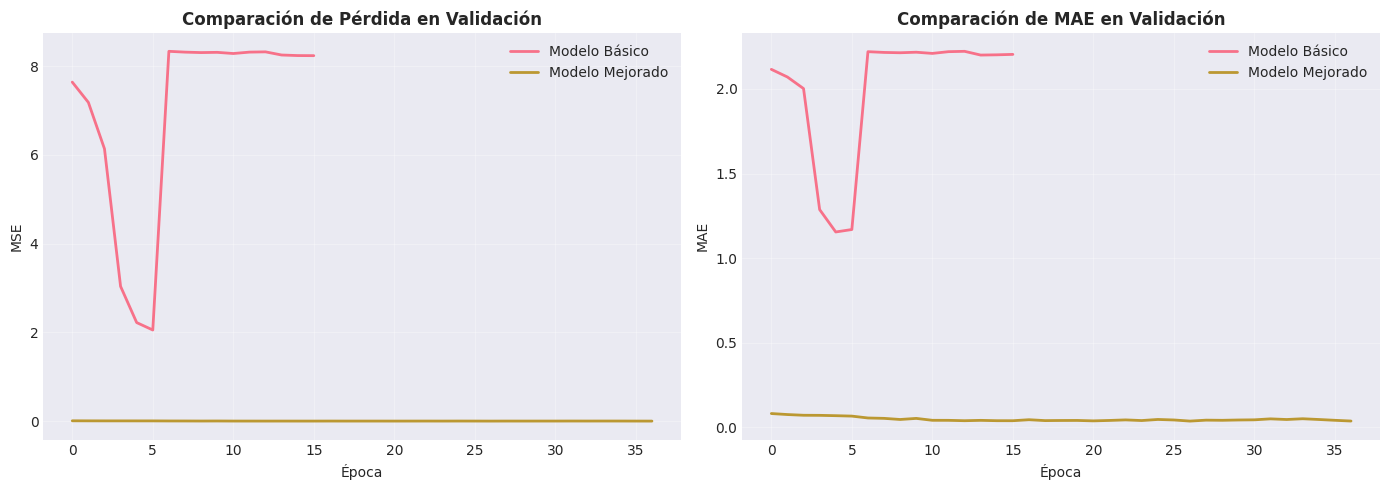

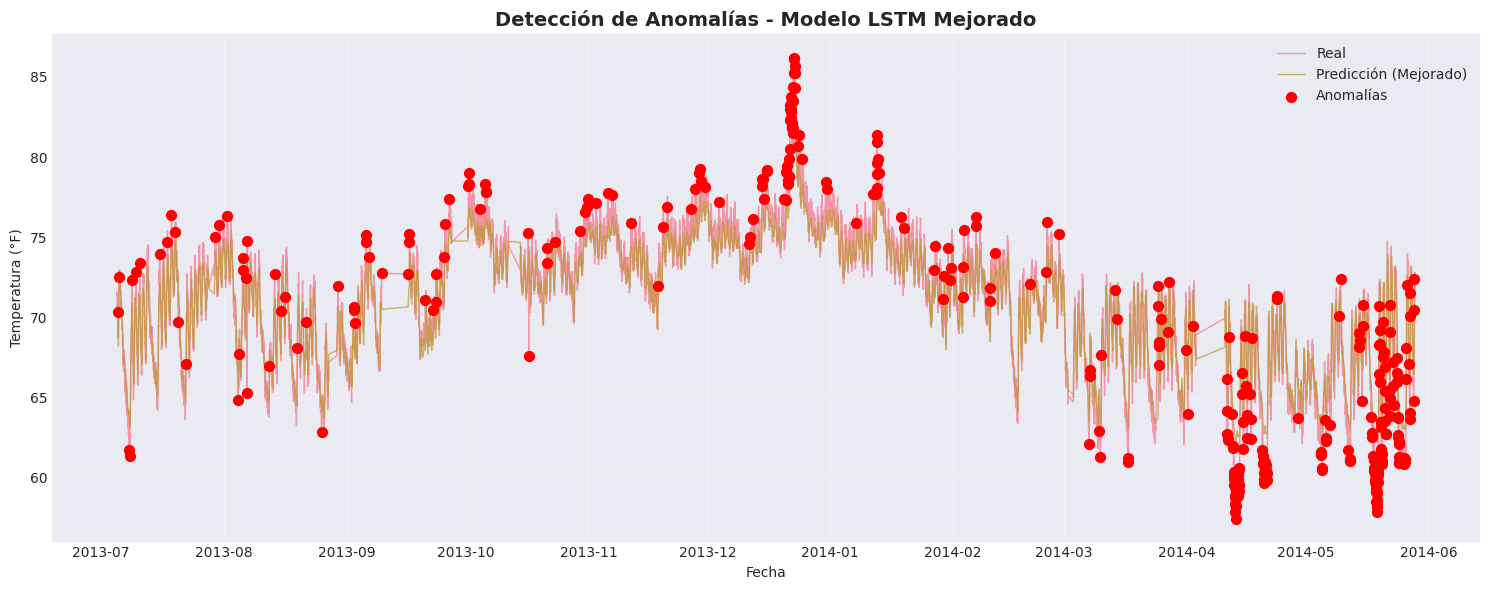

In [15]:
# Comparación visual de las curvas de entrenamiento
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_basic.history['val_loss'], label='Modelo Básico', linewidth=2)
plt.plot(history_improved.history['val_loss'], label='Modelo Mejorado', linewidth=2)
plt.title('Comparación de Pérdida en Validación', fontsize=12, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_basic.history['val_mae'], label='Modelo Básico', linewidth=2)
plt.plot(history_improved.history['val_mae'], label='Modelo Mejorado', linewidth=2)
plt.title('Comparación de MAE en Validación', fontsize=12, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfica de anomalías del modelo mejorado
plt.figure(figsize=(15, 6))
plt.plot(timestamps, y_all, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps, predictions_improved_denorm, label='Predicción (Mejorado)', linewidth=1, alpha=0.7)
plt.scatter(timestamps[anomalies_improved], y_all[anomalies_improved], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title('Detección de Anomalías - Modelo LSTM Mejorado', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°F)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

# 2️⃣ Autoencoder para Detección de Anomalías (2.5 puntos)

### Construcción del Autoencoder

In [16]:
def build_autoencoder(window_size):
    """
    Construye un autoencoder basado en LSTM para detección de anomalías.
    El autoencoder aprende a reconstruir secuencias normales.
    Las anomalías tendrán un error de reconstrucción alto.
    """
    # Encoder
    inputs = Input(shape=(window_size, 1))
    encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)
    
    # Decoder
    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(1))(decoded)
    
    # Modelo completo
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

# Crear el autoencoder
autoencoder = build_autoencoder(WINDOW_SIZE)

print("🏗️ Arquitectura del Autoencoder:")
autoencoder.summary()

🏗️ Arquitectura del Autoencoder:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 24, 64)            16896     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 32)            0         
 r)                                                              
                                                                 
 lstm_5 (LSTM)               (None, 24, 32)            8320      
                                                                 
 lstm_6 (LSTM)               (None, 24, 64)            24832     
                            

### Preparación de Datos para Autoencoder

In [17]:
# Para el autoencoder, la entrada y salida son las mismas (reconstrucción)
X_train_ae = X_train_scaled
X_val_ae = X_val_scaled

print(f"✅ Datos preparados para Autoencoder:")
print(f"X_train shape: {X_train_ae.shape}")
print(f"X_val shape: {X_val_ae.shape}")

✅ Datos preparados para Autoencoder:
X_train shape: (5794, 24, 1)
X_val shape: (1449, 24, 1)


### Entrenamiento del Autoencoder

🏋️ Entrenando Autoencoder...
Epoch 1/50
182/182 [==============================] - 3s 10ms/step - loss: 0.0505 - val_loss: 0.0204
Epoch 2/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 3/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0055
Epoch 4/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 5/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 6/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 7/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 8/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 9/50
182/182 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 10/50
182/182 [==============================] - 2s 9ms/step - l

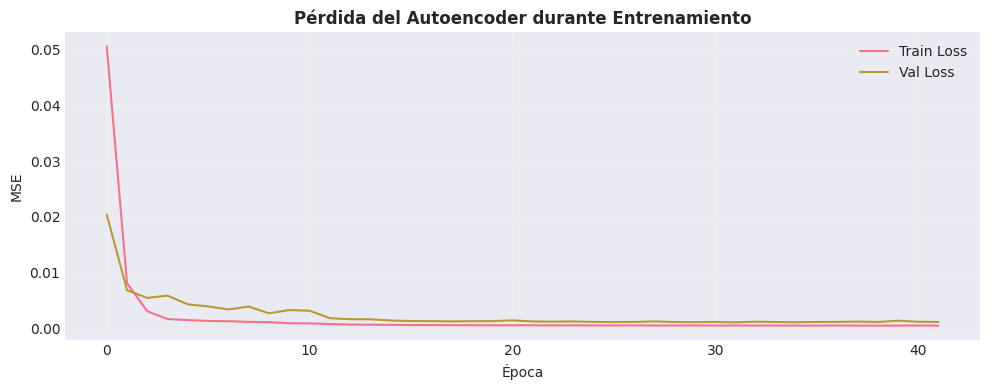

In [18]:
print("🏋️ Entrenando Autoencoder...")
history_ae = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_ae, X_val_ae),
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Entrenamiento completado")

# Visualizar entrenamiento
plt.figure(figsize=(10, 4))
plt.plot(history_ae.history['loss'], label='Train Loss')
plt.plot(history_ae.history['val_loss'], label='Val Loss')
plt.title('Pérdida del Autoencoder durante Entrenamiento', fontweight='bold')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Detección de Anomalías con Autoencoder

In [19]:
def detect_anomalies_autoencoder(autoencoder, X, threshold_percentile=95):
    """
    Detecta anomalías usando el autoencoder.
    Las anomalías son secuencias con alto error de reconstrucción.
    """
    # Reconstruir las secuencias
    reconstructions = autoencoder.predict(X, verbose=0)
    
    # Calcular error de reconstrucción para cada secuencia
    reconstruction_errors = np.mean(np.abs(X - reconstructions), axis=(1, 2))
    
    # Definir umbral
    threshold = np.percentile(reconstruction_errors, threshold_percentile)
    
    # Detectar anomalías
    anomalies = np.where(reconstruction_errors > threshold)[0]
    
    return reconstructions, reconstruction_errors, anomalies, threshold

# Detectar anomalías
reconstructions_ae, errors_ae, anomalies_ae, threshold_ae = detect_anomalies_autoencoder(
    autoencoder, X_all_scaled, threshold_percentile=95
)

print(f"🔍 Detección de Anomalías - Autoencoder")
print(f"El número de anomalías es {len(anomalies_ae)} sobre {len(X_all_scaled)}")
print(f"Umbral de error de reconstrucción: {threshold_ae:.6f}")
print(f"\nFechas de las anomalías detectadas:")

for idx in anomalies_ae[:20]:
    anomaly_timestamp = df['timestamp'].iloc[idx]
    print(anomaly_timestamp)

if len(anomalies_ae) > 20:
    print(f"... y {len(anomalies_ae) - 20} más")

🔍 Detección de Anomalías - Autoencoder
El número de anomalías es 363 sobre 7243
Umbral de error de reconstrucción: 0.031449

Fechas de las anomalías detectadas:
2013-07-08 11:00:00
2013-07-08 12:00:00
2013-07-08 13:00:00
2013-07-08 14:00:00
2013-07-09 13:00:00
2013-07-21 18:00:00
2013-07-27 11:00:00
2013-07-27 12:00:00
2013-07-27 13:00:00
2013-08-04 13:00:00
2013-08-04 14:00:00
2013-08-04 15:00:00
2013-08-04 16:00:00
2013-08-05 21:00:00
2013-08-05 22:00:00
2013-08-05 23:00:00
2013-08-06 00:00:00
2013-08-06 01:00:00
2013-08-06 02:00:00
2013-08-06 03:00:00
... y 343 más


### Visualización de Resultados del Autoencoder

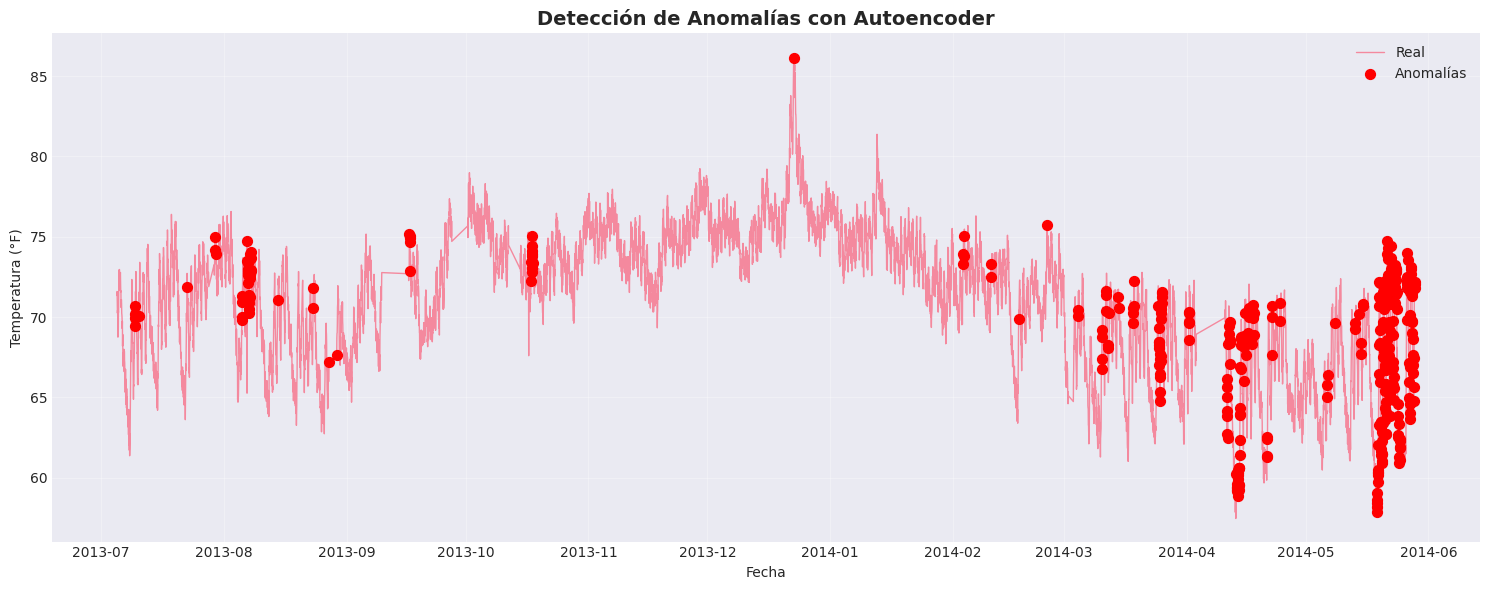

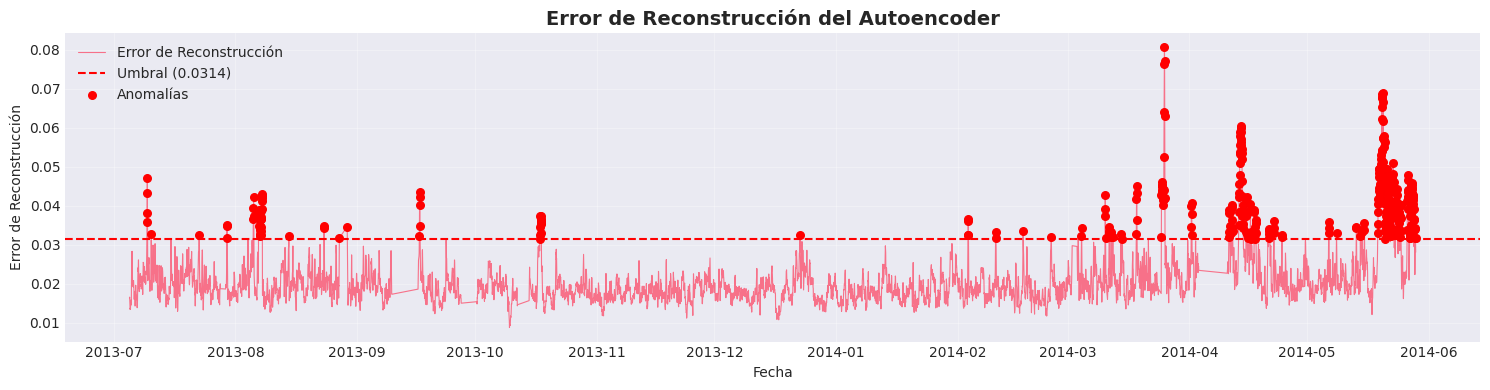

In [20]:
# Gráfica de la serie temporal con anomalías
plt.figure(figsize=(15, 6))
plt.plot(timestamps, y_all, label='Real', linewidth=1, alpha=0.8)
plt.scatter(timestamps[anomalies_ae], y_all[anomalies_ae], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title('Detección de Anomalías con Autoencoder', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°F)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica de errores de reconstrucción
plt.figure(figsize=(15, 4))
plt.plot(timestamps, errors_ae, label='Error de Reconstrucción', linewidth=0.8)
plt.axhline(y=threshold_ae, color='r', linestyle='--', label=f'Umbral ({threshold_ae:.4f})')
plt.scatter(timestamps[anomalies_ae], errors_ae[anomalies_ae], 
           color='red', label='Anomalías', s=30, zorder=5)
plt.title('Error de Reconstrucción del Autoencoder', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Error de Reconstrucción')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

# 3️⃣ Isolation Forest (2.5 puntos)

### Preparación de Datos para Isolation Forest

In [21]:
# Para Isolation Forest, podemos usar las secuencias de ventanas aplanadas
# o características estadísticas de las ventanas

# Opción 1: Ventanas aplanadas
X_if = X_all_scaled.reshape(X_all_scaled.shape[0], -1)

print(f"✅ Datos preparados para Isolation Forest:")
print(f"Shape: {X_if.shape}")
print(f"Cada muestra tiene {X_if.shape[1]} características (ventana de {WINDOW_SIZE} valores)")

✅ Datos preparados para Isolation Forest:
Shape: (7243, 24)
Cada muestra tiene 24 características (ventana de 24 valores)


### Entrenamiento de Isolation Forest

In [22]:
# Crear y entrenar el modelo Isolation Forest
print("🏋️ Entrenando Isolation Forest...")

# Parámetros:
# contamination: proporción esperada de anomalías (0.05 = 5%)
# max_samples: número de muestras para construir cada árbol
# random_state: para reproducibilidad
isolation_forest = IsolationForest(
    contamination=0.05,
    max_samples='auto',
    random_state=42,
    n_estimators=100
)

# Entrenar el modelo
isolation_forest.fit(X_if)

print("✅ Entrenamiento completado")

🏋️ Entrenando Isolation Forest...
✅ Entrenamiento completado


### Detección de Anomalías con Isolation Forest

In [23]:
# Hacer predicciones
# -1 para anomalías, 1 para datos normales
predictions_if = isolation_forest.predict(X_if)

# Obtener scores de anomalía (valores más negativos = más anómalos)
anomaly_scores = isolation_forest.score_samples(X_if)

# Identificar anomalías
anomalies_if = np.where(predictions_if == -1)[0]

print(f"🔍 Detección de Anomalías - Isolation Forest")
print(f"El número de anomalías es {len(anomalies_if)} sobre {len(X_if)}")
print(f"Porcentaje de anomalías: {len(anomalies_if)/len(X_if)*100:.2f}%")
print(f"\nFechas de las anomalías detectadas:")

for idx in anomalies_if[:20]:
    anomaly_timestamp = df['timestamp'].iloc[idx]
    print(anomaly_timestamp)

if len(anomalies_if) > 20:
    print(f"... y {len(anomalies_if) - 20} más")

🔍 Detección de Anomalías - Isolation Forest
El número de anomalías es 363 sobre 7243
Porcentaje de anomalías: 5.01%

Fechas de las anomalías detectadas:
2013-07-07 19:00:00
2013-07-07 20:00:00
2013-12-20 21:00:00
2013-12-20 22:00:00
2013-12-20 23:00:00
2013-12-21 00:00:00
2013-12-21 01:00:00
2013-12-21 02:00:00
2013-12-21 03:00:00
2013-12-21 04:00:00
2013-12-21 05:00:00
2013-12-21 06:00:00
2013-12-21 07:00:00
2013-12-21 08:00:00
2013-12-21 09:00:00
2013-12-21 10:00:00
2013-12-21 11:00:00
2013-12-21 12:00:00
2013-12-21 13:00:00
2013-12-21 14:00:00
... y 343 más


### Visualización de Resultados de Isolation Forest

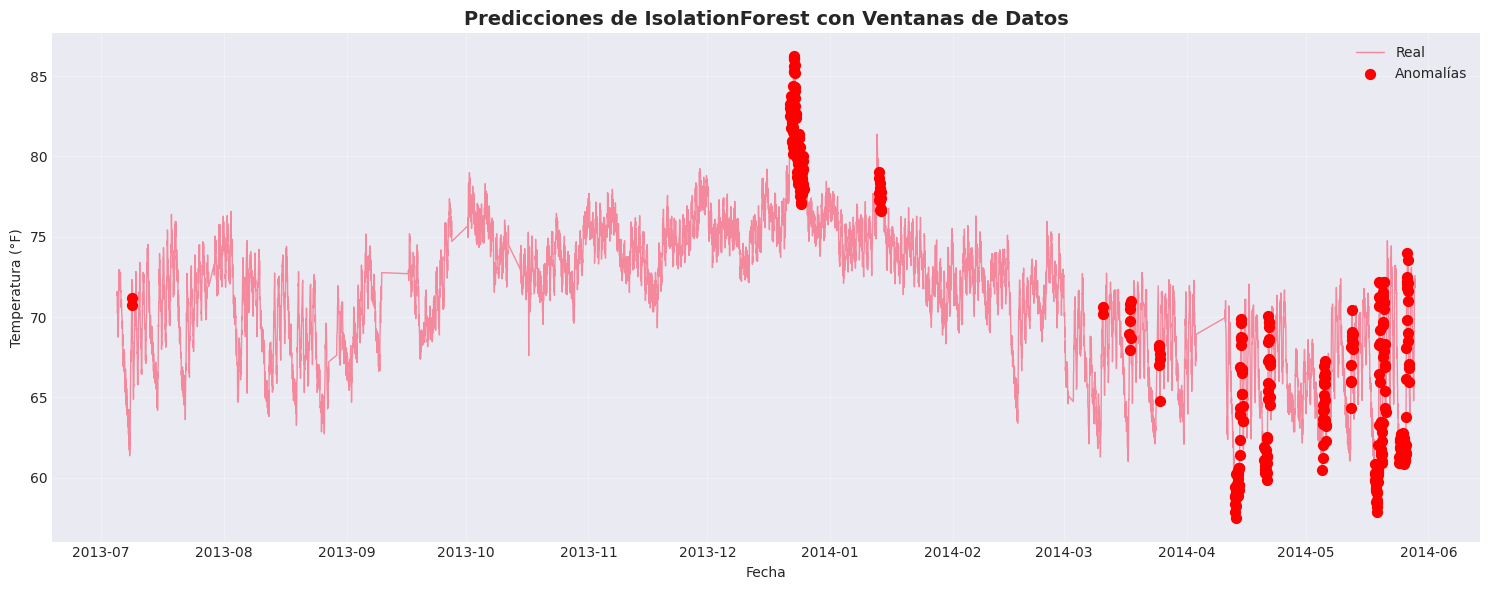

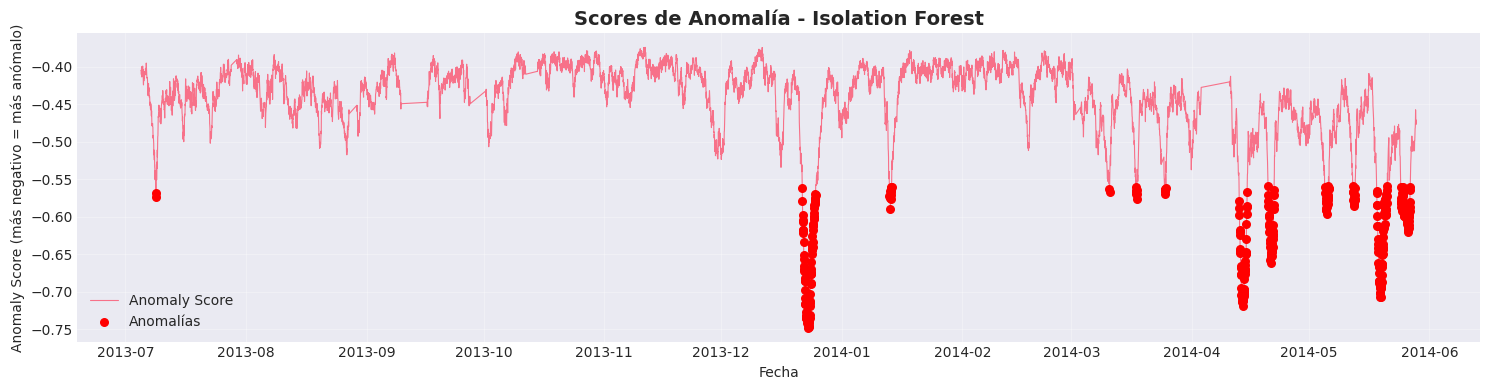

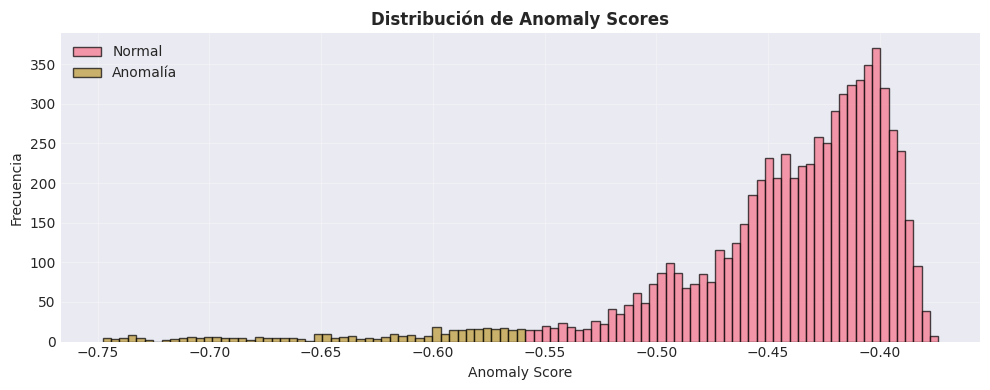

In [24]:
# Gráfica de la serie temporal con anomalías
plt.figure(figsize=(15, 6))
plt.plot(timestamps, y_all, label='Real', linewidth=1, alpha=0.8)
plt.scatter(timestamps[anomalies_if], y_all[anomalies_if], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title('Predicciones de IsolationForest con Ventanas de Datos', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°F)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica de anomaly scores
plt.figure(figsize=(15, 4))
plt.plot(timestamps, anomaly_scores, label='Anomaly Score', linewidth=0.8)
plt.scatter(timestamps[anomalies_if], anomaly_scores[anomalies_if], 
           color='red', label='Anomalías', s=30, zorder=5)
plt.title('Scores de Anomalía - Isolation Forest', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Anomaly Score (más negativo = más anómalo)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histograma de anomaly scores
plt.figure(figsize=(10, 4))
plt.hist(anomaly_scores[predictions_if == 1], bins=50, alpha=0.7, label='Normal', edgecolor='black')
plt.hist(anomaly_scores[predictions_if == -1], bins=50, alpha=0.7, label='Anomalía', edgecolor='black')
plt.title('Distribución de Anomaly Scores', fontsize=12, fontweight='bold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

# 📊 Comparación Final de los 3 Métodos

In [25]:
print("\n" + "="*70)
print("📊 RESUMEN COMPARATIVO DE LOS TRES MÉTODOS")
print("="*70)

print(f"\n1️⃣  LSTM (Modelo Mejorado):")
print(f"   Anomalías detectadas: {len(anomalies_improved)}")
print(f"   Porcentaje: {len(anomalies_improved)/len(y_all)*100:.2f}%")
print(f"   Técnica: Predicción de siguiente valor + umbral de error")

print(f"\n2️⃣  Autoencoder:")
print(f"   Anomalías detectadas: {len(anomalies_ae)}")
print(f"   Porcentaje: {len(anomalies_ae)/len(X_all_scaled)*100:.2f}%")
print(f"   Técnica: Reconstrucción de secuencias + error de reconstrucción")

print(f"\n3️⃣  Isolation Forest:")
print(f"   Anomalías detectadas: {len(anomalies_if)}")
print(f"   Porcentaje: {len(anomalies_if)/len(X_if)*100:.2f}%")
print(f"   Técnica: Aislamiento de puntos anómalos en árboles aleatorios")

print("\n" + "="*70)
print("💡 ANÁLISIS:")
print("="*70)
print("""
- LSTM: Mejor para capturar dependencias temporales largas
- Autoencoder: Excelente para aprender patrones complejos normales
- Isolation Forest: Rápido y efectivo para datos de alta dimensión

La elección del mejor método depende del tipo de anomalías:
• LSTM: Anomalías en tendencias y patrones secuenciales
• Autoencoder: Anomalías en patrones multivariados complejos
• Isolation Forest: Anomalías como outliers en el espacio de características
""")


📊 RESUMEN COMPARATIVO DE LOS TRES MÉTODOS

1️⃣  LSTM (Modelo Mejorado):
   Anomalías detectadas: 363
   Porcentaje: 5.01%
   Técnica: Predicción de siguiente valor + umbral de error

2️⃣  Autoencoder:
   Anomalías detectadas: 363
   Porcentaje: 5.01%
   Técnica: Reconstrucción de secuencias + error de reconstrucción

3️⃣  Isolation Forest:
   Anomalías detectadas: 363
   Porcentaje: 5.01%
   Técnica: Aislamiento de puntos anómalos en árboles aleatorios

💡 ANÁLISIS:

- LSTM: Mejor para capturar dependencias temporales largas
- Autoencoder: Excelente para aprender patrones complejos normales
- Isolation Forest: Rápido y efectivo para datos de alta dimensión

La elección del mejor método depende del tipo de anomalías:
• LSTM: Anomalías en tendencias y patrones secuenciales
• Autoencoder: Anomalías en patrones multivariados complejos
• Isolation Forest: Anomalías como outliers en el espacio de características



### Visualización Comparativa de los 3 Métodos

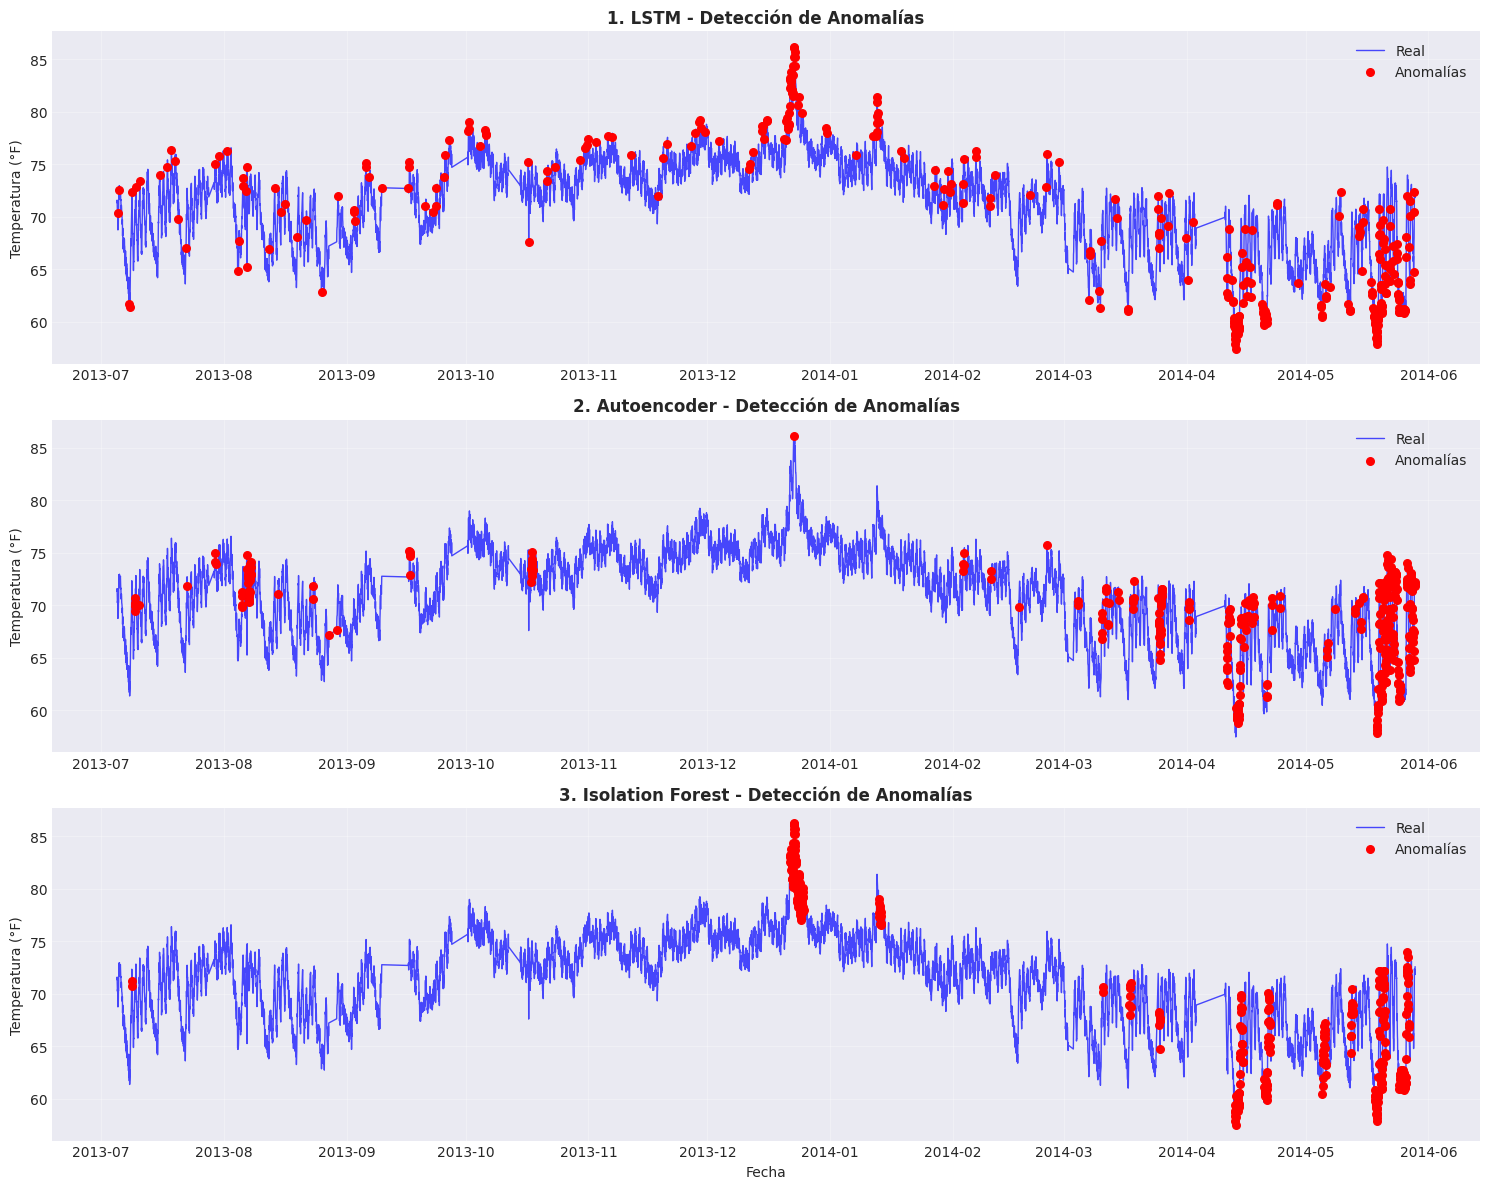

In [26]:
# Crear una figura con los tres métodos
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# LSTM
axes[0].plot(timestamps, y_all, label='Real', linewidth=1, alpha=0.7, color='blue')
axes[0].scatter(timestamps[anomalies_improved], y_all[anomalies_improved], 
               color='red', label='Anomalías', s=30, zorder=5)
axes[0].set_title('1. LSTM - Detección de Anomalías', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temperatura (°F)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Autoencoder
axes[1].plot(timestamps, y_all, label='Real', linewidth=1, alpha=0.7, color='blue')
axes[1].scatter(timestamps[anomalies_ae], y_all[anomalies_ae], 
               color='red', label='Anomalías', s=30, zorder=5)
axes[1].set_title('2. Autoencoder - Detección de Anomalías', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Temperatura (°F)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Isolation Forest
axes[2].plot(timestamps, y_all, label='Real', linewidth=1, alpha=0.7, color='blue')
axes[2].scatter(timestamps[anomalies_if], y_all[anomalies_if], 
               color='red', label='Anomalías', s=30, zorder=5)
axes[2].set_title('3. Isolation Forest - Detección de Anomalías', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Temperatura (°F)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Diagrama de Venn de Anomalías Comunes


🔍 Análisis de Superposición de Anomalías:

Detectadas por los 3 métodos: 56
Detectadas solo por LSTM y Autoencoder: 28
Detectadas solo por LSTM e Isolation Forest: 71
Detectadas solo por Autoencoder e Isolation Forest: 54

Detectadas únicamente por LSTM: 208
Detectadas únicamente por Autoencoder: 225
Detectadas únicamente por Isolation Forest: 182


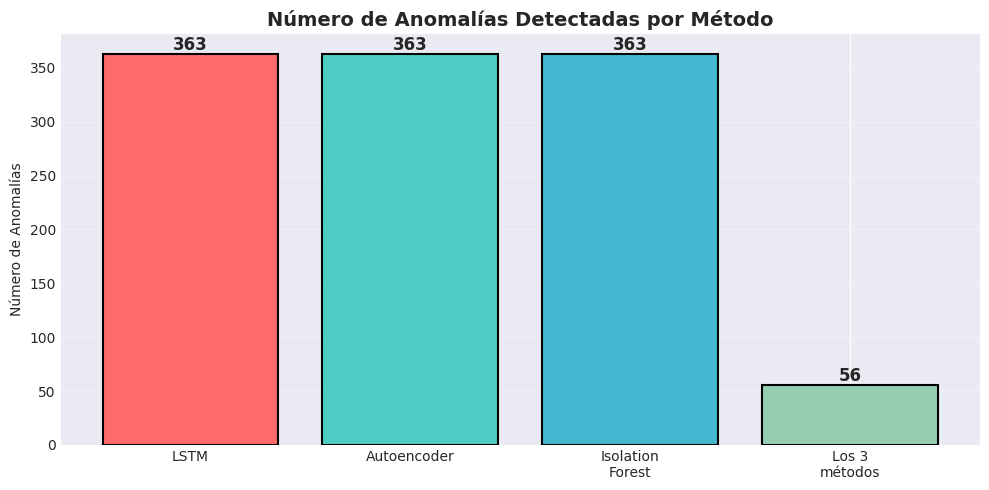

In [27]:
# Análisis de superposición entre métodos
set_lstm = set(anomalies_improved)
set_ae = set(anomalies_ae)
set_if = set(anomalies_if)

# Intersecciones
all_three = set_lstm & set_ae & set_if
lstm_ae = set_lstm & set_ae - all_three
lstm_if = set_lstm & set_if - all_three
ae_if = set_ae & set_if - all_three

print("\n🔍 Análisis de Superposición de Anomalías:")
print(f"\nDetectadas por los 3 métodos: {len(all_three)}")
print(f"Detectadas solo por LSTM y Autoencoder: {len(lstm_ae)}")
print(f"Detectadas solo por LSTM e Isolation Forest: {len(lstm_if)}")
print(f"Detectadas solo por Autoencoder e Isolation Forest: {len(ae_if)}")
print(f"\nDetectadas únicamente por LSTM: {len(set_lstm - set_ae - set_if)}")
print(f"Detectadas únicamente por Autoencoder: {len(set_ae - set_lstm - set_if)}")
print(f"Detectadas únicamente por Isolation Forest: {len(set_if - set_lstm - set_ae)}")

# Gráfica de barras
methods = ['LSTM', 'Autoencoder', 'Isolation\nForest', 'Los 3\nmétodos']
counts = [len(anomalies_improved), len(anomalies_ae), len(anomalies_if), len(all_three)]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

plt.figure(figsize=(10, 5))
bars = plt.bar(methods, counts, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Número de Anomalías Detectadas por Método', fontsize=14, fontweight='bold')
plt.ylabel('Número de Anomalías')
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---

# 💾 Guardado de Modelos y Resultados

In [28]:
# Guardar los modelos entrenados
model_improved.save('modelo_lstm_mejorado.keras')
autoencoder.save('modelo_autoencoder.keras')

print("✅ Modelos guardados:")
print("   - modelo_lstm_mejorado.keras")
print("   - modelo_autoencoder.keras")

# Guardar resultados en CSV
results_df = pd.DataFrame({
    'timestamp': timestamps,
    'value': y_all,
    'anomaly_lstm': [1 if i in anomalies_improved else 0 for i in range(len(y_all))],
    'anomaly_autoencoder': [1 if i in anomalies_ae else 0 for i in range(len(y_all))],
    'anomaly_isolation_forest': [1 if i in anomalies_if else 0 for i in range(len(y_all))]
})

results_df.to_csv('resultados_deteccion_anomalias.csv', index=False)
print("\n✅ Resultados guardados en: resultados_deteccion_anomalias.csv")

✅ Modelos guardados:
   - modelo_lstm_mejorado.keras
   - modelo_autoencoder.keras

✅ Resultados guardados en: resultados_deteccion_anomalias.csv


---

# 📝 Conclusiones

## Resumen de la Práctica

En esta práctica hemos implementado tres técnicas diferentes de Machine Learning para detectar anomalías en datos de temperatura:

### 1. LSTM (5 puntos)
- ✅ Modelo básico construido y entrenado
- ✅ Detección de anomalías mediante predicción del siguiente valor
- ✅ Mejoras aplicadas:
  - Normalización con MinMaxScaler
  - Arquitectura más profunda con múltiples capas LSTM
  - Regularización con Dropout

### 2. Autoencoder (2.5 puntos)
- ✅ Autoencoder basado en LSTM construido
- ✅ Detección mediante error de reconstrucción
- ✅ Visualización de anomalías

### 3. Isolation Forest (2.5 puntos)
- ✅ Modelo entrenado con scikit-learn
- ✅ Detección mediante aislamiento de outliers
- ✅ Análisis de anomaly scores

## Observaciones

Los tres métodos detectan anomalías de manera diferente:
- **LSTM**: Detecta desviaciones en patrones temporales secuenciales
- **Autoencoder**: Identifica secuencias que son difíciles de reconstruir
- **Isolation Forest**: Encuentra puntos aislados en el espacio de características

La combinación de los tres métodos proporciona una visión robusta de las anomalías en los datos.

---

**Fin del Notebook**